# BBC News Classification: Unsupervised Learning VS Supervised Learning

I will utilize a publicly available dataset from the BBC, which can be accessed at https://www.kaggle.com/competitions/learn-ai-bbc/overview. My approach will involve applying Non-Negative Matrix Factorization (NMF) for topic modeling, followed by a supervised learning model for classification. The performance of these two methods will be compared to evaluate their effectiveness in text analysis.

## 1. Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data


In [54]:
# basics
import numpy as np
import itertools
import random
import os

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import nltk
import ssl
import spacy
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Unsupervised learning
from sklearn.decomposition import NMF

# Supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# helper functions
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV

In [59]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [60]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [43]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        if not filename.startswith('.'):  # Skip hidden files
            print(os.path.join(dirname, filename))

./data/BBC News Train.csv
./data/BBC News Test.csv
./data/BBC News Sample Solution.csv


In [44]:
train_data = pd.read_csv('./data/BBC News Train.csv')
test_data = pd.read_csv('./data/BBC News Test.csv')
sample_data = pd.read_csv('./data/BBC News Sample Solution.csv')

In [45]:
print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Initial look shows there are 3 columns(ArticleId, Text and Category) and 1490 rows.

In [46]:
train_data.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

There are no null values in this data, which makes it very easy to work with, since there is minimal work required for cleaning data.
Let's see if there are any duplicates in this data.

In [47]:
# Checking for duplicate entries
duplicate_texts = train_data['Text'].duplicated().sum()

print(f'Number of duplicate texts: {duplicate_texts}')
print('Example of duplicated article:')
train_data.iloc[[62, 157], :2]

Number of duplicate texts: 50
Example of duplicated article:


,ArticleId,Text
62,476,prince crowned top music earner prince earne...
157,853,prince crowned top music earner prince earne...


There are some clean up to do as there are duplicated articles, which need to be removed.

In [48]:
# Dropping duplicate entries
train_data = train_data.drop_duplicates(subset=['Text'])

# Checking the shape of the data after the duplicate entries were dropped
train_data.shape

(1440, 3)

After removing duplicates, now there are 1440 rows which makes sense since there were 50 duplicates found(1490-50 = 1440).
Let's check out how articles are distributed.

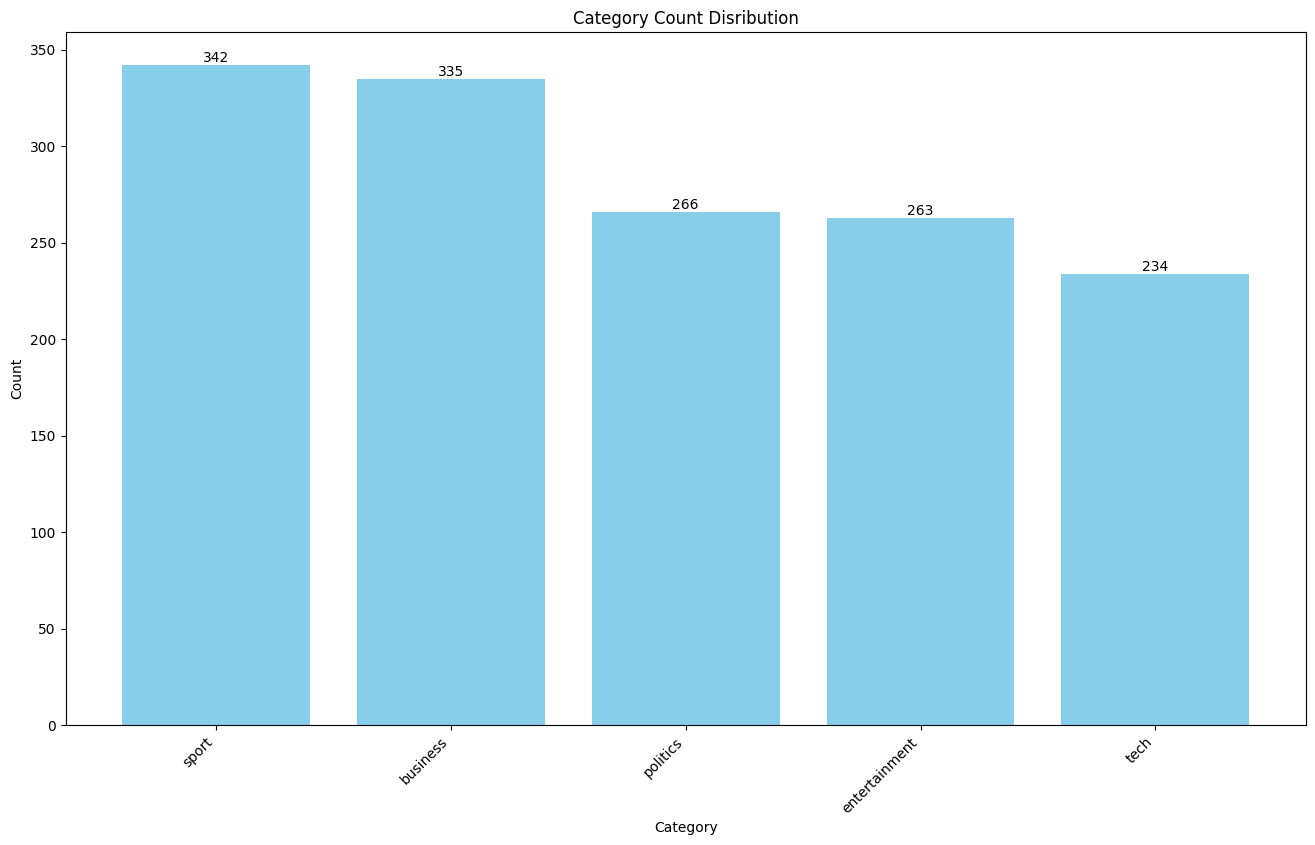

In [49]:
# Plot histogram of number of articles per category
category_counts = train_data['Category'].value_counts()
plt.figure(figsize=(16, 9))
plt.bar(category_counts.index, category_counts, color='skyblue')
plt.title('Category Count Disribution')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
for i, count in enumerate(category_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

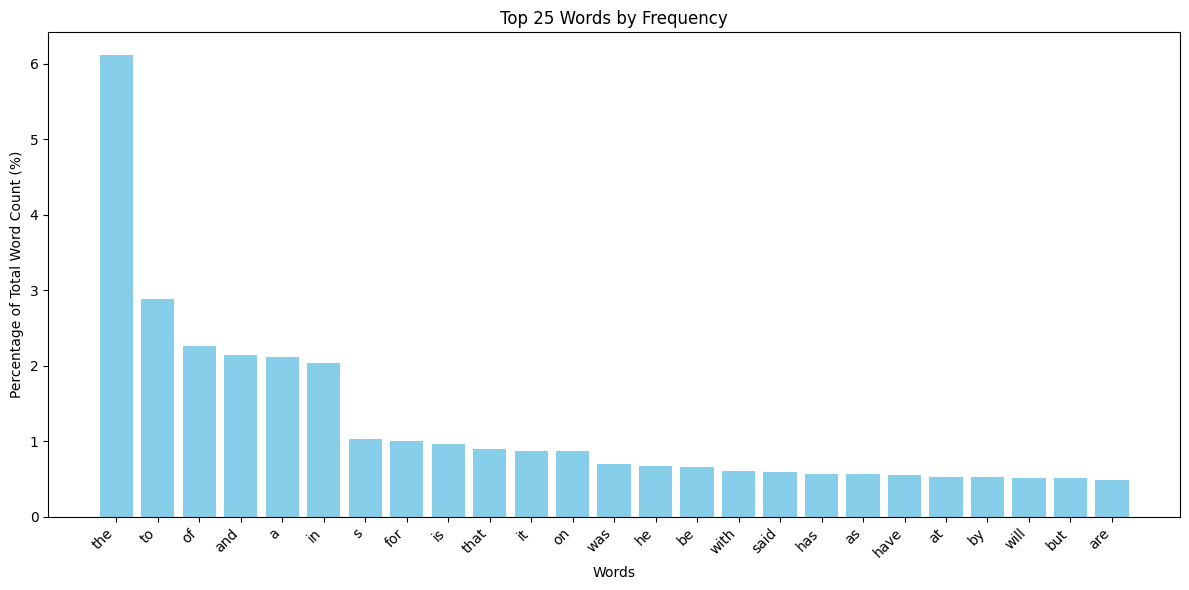

In [50]:
# Plot top 25 words by frequency
frequency = train_data['Text'].str.split(expand=True).unstack().value_counts()
freqplot = frequency[:25] / np.sum(frequency) * 100

plt.figure(figsize=(12, 6))
plt.bar(freqplot.index, freqplot.values, color='skyblue')
plt.title('Top 25 Words by Frequency')
plt.xlabel('Words')
plt.ylabel('Percentage of Total Word Count (%)')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

None of these words are meaningful word that can be categorized into certain categories. I'll use the help of libraries to extract key words.

### Feature Extraction

In order to analysis my dateset with Machine Learning methods, I need to transform each article's text to a feature vector. Use the TF-IDF (Term Frequency-Inverse Document Frequency) to capture the importance of words within a document and across the entire dataset. This will creates a document-term matrix where rows represent documents and columns represent unique words.

### Data Preprocessing

Before extracting the features, cleaning up the data would be good idea.

In [51]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocessing_data(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove digits and punctuation using regex
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Return the processed text
    return ' '.join(tokens)

# Example usage for processing training data
processed_train_data = [preprocessing_data(data) for data in train_data['Text']]

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/judoboyalex/nltk_data'
    - '/Users/judoboyalex/Documents/.venv/nltk_data'
    - '/Users/judoboyalex/Documents/.venv/share/nltk_data'
    - '/Users/judoboyalex/Documents/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


Explanation of changes:
Tokenization: word_tokenize from nltk splits the text into words.
Lemmatization: WordNetLemmatizer is used to lemmatize words.
Stopwords Removal: NLTK's stopwords corpus is used to filter out common stopwords.
Punctuation/Digit Removal: re.sub() is used to remove digits and punctuation.

In [ ]:
# Print an example of the cleaned text
processed_train_data[0]